In [1]:
import numpy as np
import sys
import time
import random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pickle 

import torch
import torch.nn as nn
import torch.optim as optim

sys.path.append('/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm')

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from word2vec_eltdm.common import Tokenizer, VocabCreator, DataLoader, TokenCleaner, Preprocessor, Subsampler, evaluate, visualization_tsne
from word2vec_eltdm.word2vec_accelerated import PytorchNegWord2Vec, NegativeSamplingLoss, train_NSL, update_best_loss

## Get data and create vocab

In [3]:
datapath = "../data/text8.txt"

RATIO = 1
return_only_train = True
tokenizer = Tokenizer(datapath)
token_cleaner = TokenCleaner(freq_threshold=5)
vocab_creator = VocabCreator()
text8_dataset = Preprocessor(tokenizer, token_cleaner, vocab_creator, RATIO, return_only_train).preprocess()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print("Size of our vocabulary:", len(text8_dataset.tokens_to_id))

Size of our vocabulary: 63492


In [5]:
print("Number of tokens in our train dataset:", len(text8_dataset.train_tokens))

Number of tokens in our train dataset: 10566033


In [6]:
print("Number of tokens in our val dataset:", len(text8_dataset.val_tokens))

Number of tokens in our val dataset: 0


In [7]:
print("Number of tokens in our test dataset:", len(text8_dataset.test_tokens))

Number of tokens in our test dataset: 0


## Subsampling of frequent words, as in Mikolov 2013.

In [8]:
subsampler = Subsampler(text8_dataset.train_tokens)
text8_dataset.train_tokens, text8_dataset.frequencies = subsampler.subsample()

In [9]:
print("Size of our vocabulary after subsampling of frequent words, for train:", len(text8_dataset.tokens_to_id))

Size of our vocabulary after subsampling of frequent words, for train: 63492


In [10]:
print("Number of tokens in train dataset:", len(text8_dataset.train_tokens))

Number of tokens in train dataset: 3767955


## DataLoader

In [11]:
window = 5
batch_size = 512
train_dataloader = DataLoader(text8_dataset, text8_dataset.train_tokens, window, batch_size)

## Model

In [12]:
# defining the parameters
len_vocab = len(text8_dataset.tokens_to_id)
embedding_size = 300
learning_rate = 0.003
n_samples = 5
epochs = 1

# Get our noise distribution
word_freqs = np.array(sorted(text8_dataset.frequencies.values(), reverse=True))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75))

# instantiate the model
model = PytorchNegWord2Vec(
    len_vocab,
    embedding_size,
    noise_dist=noise_dist,
    device=device
).to(device)
model.initialize_weights()

criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [14]:
# train for some number of epochs

# takes about 1:03 minutes per epoch

train_loss_history = []
tbar = trange(epochs)

for epoch in tbar:
    print(f"###################### EPOCH {epoch} ###########################")
    
    train_loss = train_NSL(model, train_dataloader, criterion, optimizer, n_samples, device)
    print("Training loss:", train_loss.item())
    train_loss_history.append(train_loss.item())
    
    # Keep track of the best model
    update_best_loss(model, train_loss, device)
    
    embeddings = model.embedding_input.weight.data.detach().cpu().numpy()
    evaluate(embeddings, text8_dataset.id_to_tokens, nb_words=20)

  0%|          | 0/2 [00:00<?, ?it/s]

###################### EPOCH 0 ###########################


  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 3.28481
Current Training Loss 2.79298
Current Training Loss 2.85339
Current Training Loss 2.83707
Current Training Loss 2.76733
Training loss: 2.869513988494873
Now best model has 2.869513988494873 loss
Saving model
year | years, january, months, day, leap
x | z, p, k, c, n
external | links, com, references, website, list
century | medieval, th, ancient, ages, centuries
links | external, com, website, references, html
english | french, italian, writer, scottish, b
would | able, finally, could, time, turn
states | united, state, city, washington, federal
united | states, former, government, presidents, union
series | games, first, tv, game, season
remaining | calendar, victory, gregorian, year, days
reached | record, declared, managed, romania, peaked
animal | animals, species, skin, feed, tissue
billion | exports, imports, commodities, oil, revenues
signed | treaty, agreement, agreements, treaties, union
individuals | result, sexual, cases, risk, argue
hebrew | je

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.533
Current Training Loss 2.31031
Current Training Loss 2.64775
Current Training Loss 2.42903
Current Training Loss 2.42927
Training loss: 2.496751308441162
Now best model has 2.496751308441162 loss
Saving model
century | centuries, ages, th, medieval, modern
would | thus, promised, even, could, able
example | means, word, always, used, similar
english | french, politician, b, poet, william
states | united, state, north, u, largest
known | called, probably, modern, earliest, originally
like | using, example, called, used, character
different | common, used, using, commonly, usually
much | even, high, therefore, less, process
war | uprising, troops, forces, allied, army
wars | battles, fought, war, army, battle
computers | computer, processor, machines, ibm, technology
medicine | medical, physiology, study, health, nobel
motion | moon, planetary, energy, frame, newton
translation | translated, translations, text, transcribed, edited
supported | support, technolog

## Evaluation on the task of word similarities

In [15]:
filepath = "../word2vec_eltdm/models/PytorchNegWord2Vec_2.496751308441162.p"
with open(filepath, "rb") as file:
    model = pickle.load(file)

In [16]:
model = model["PytorchNegWord2Vec"]
embeddings = model.embedding_input.weight.data.numpy()

### Evaluate using cosine similarity

In [17]:
evaluate(embeddings, text8_dataset.id_to_tokens, nb_words=20)

history | ed, also, online, website, press
early | century, late, th, included, history
language | languages, dialects, speakers, dialect, spoken
different | common, used, using, commonly, usually
also | called, external, history, include, type
name | called, named, originally, zero, one
well | many, frequently, mostly, ranging, also
since | dominate, system, using, time, based
five | seven, six, two, zero, eight
see | links, external, list, applied, also
lack | increase, effective, diseases, control, traits
billion | million, exports, debt, imports, reserves
regarded | secular, categories, marriage, position, controversial
table | tables, symbol, contain, specify, values
internal | output, storage, transfer, able, components
response | impulses, inhibit, inflammatory, effect, causes
hebrew | jewish, judaism, aramaic, torah, tanakh
composer | b, poet, laureate, actress, american
location | access, part, sections, valleys, across
translation | translated, translations, text, transcribed

### t-SNE embedding visualisation

/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


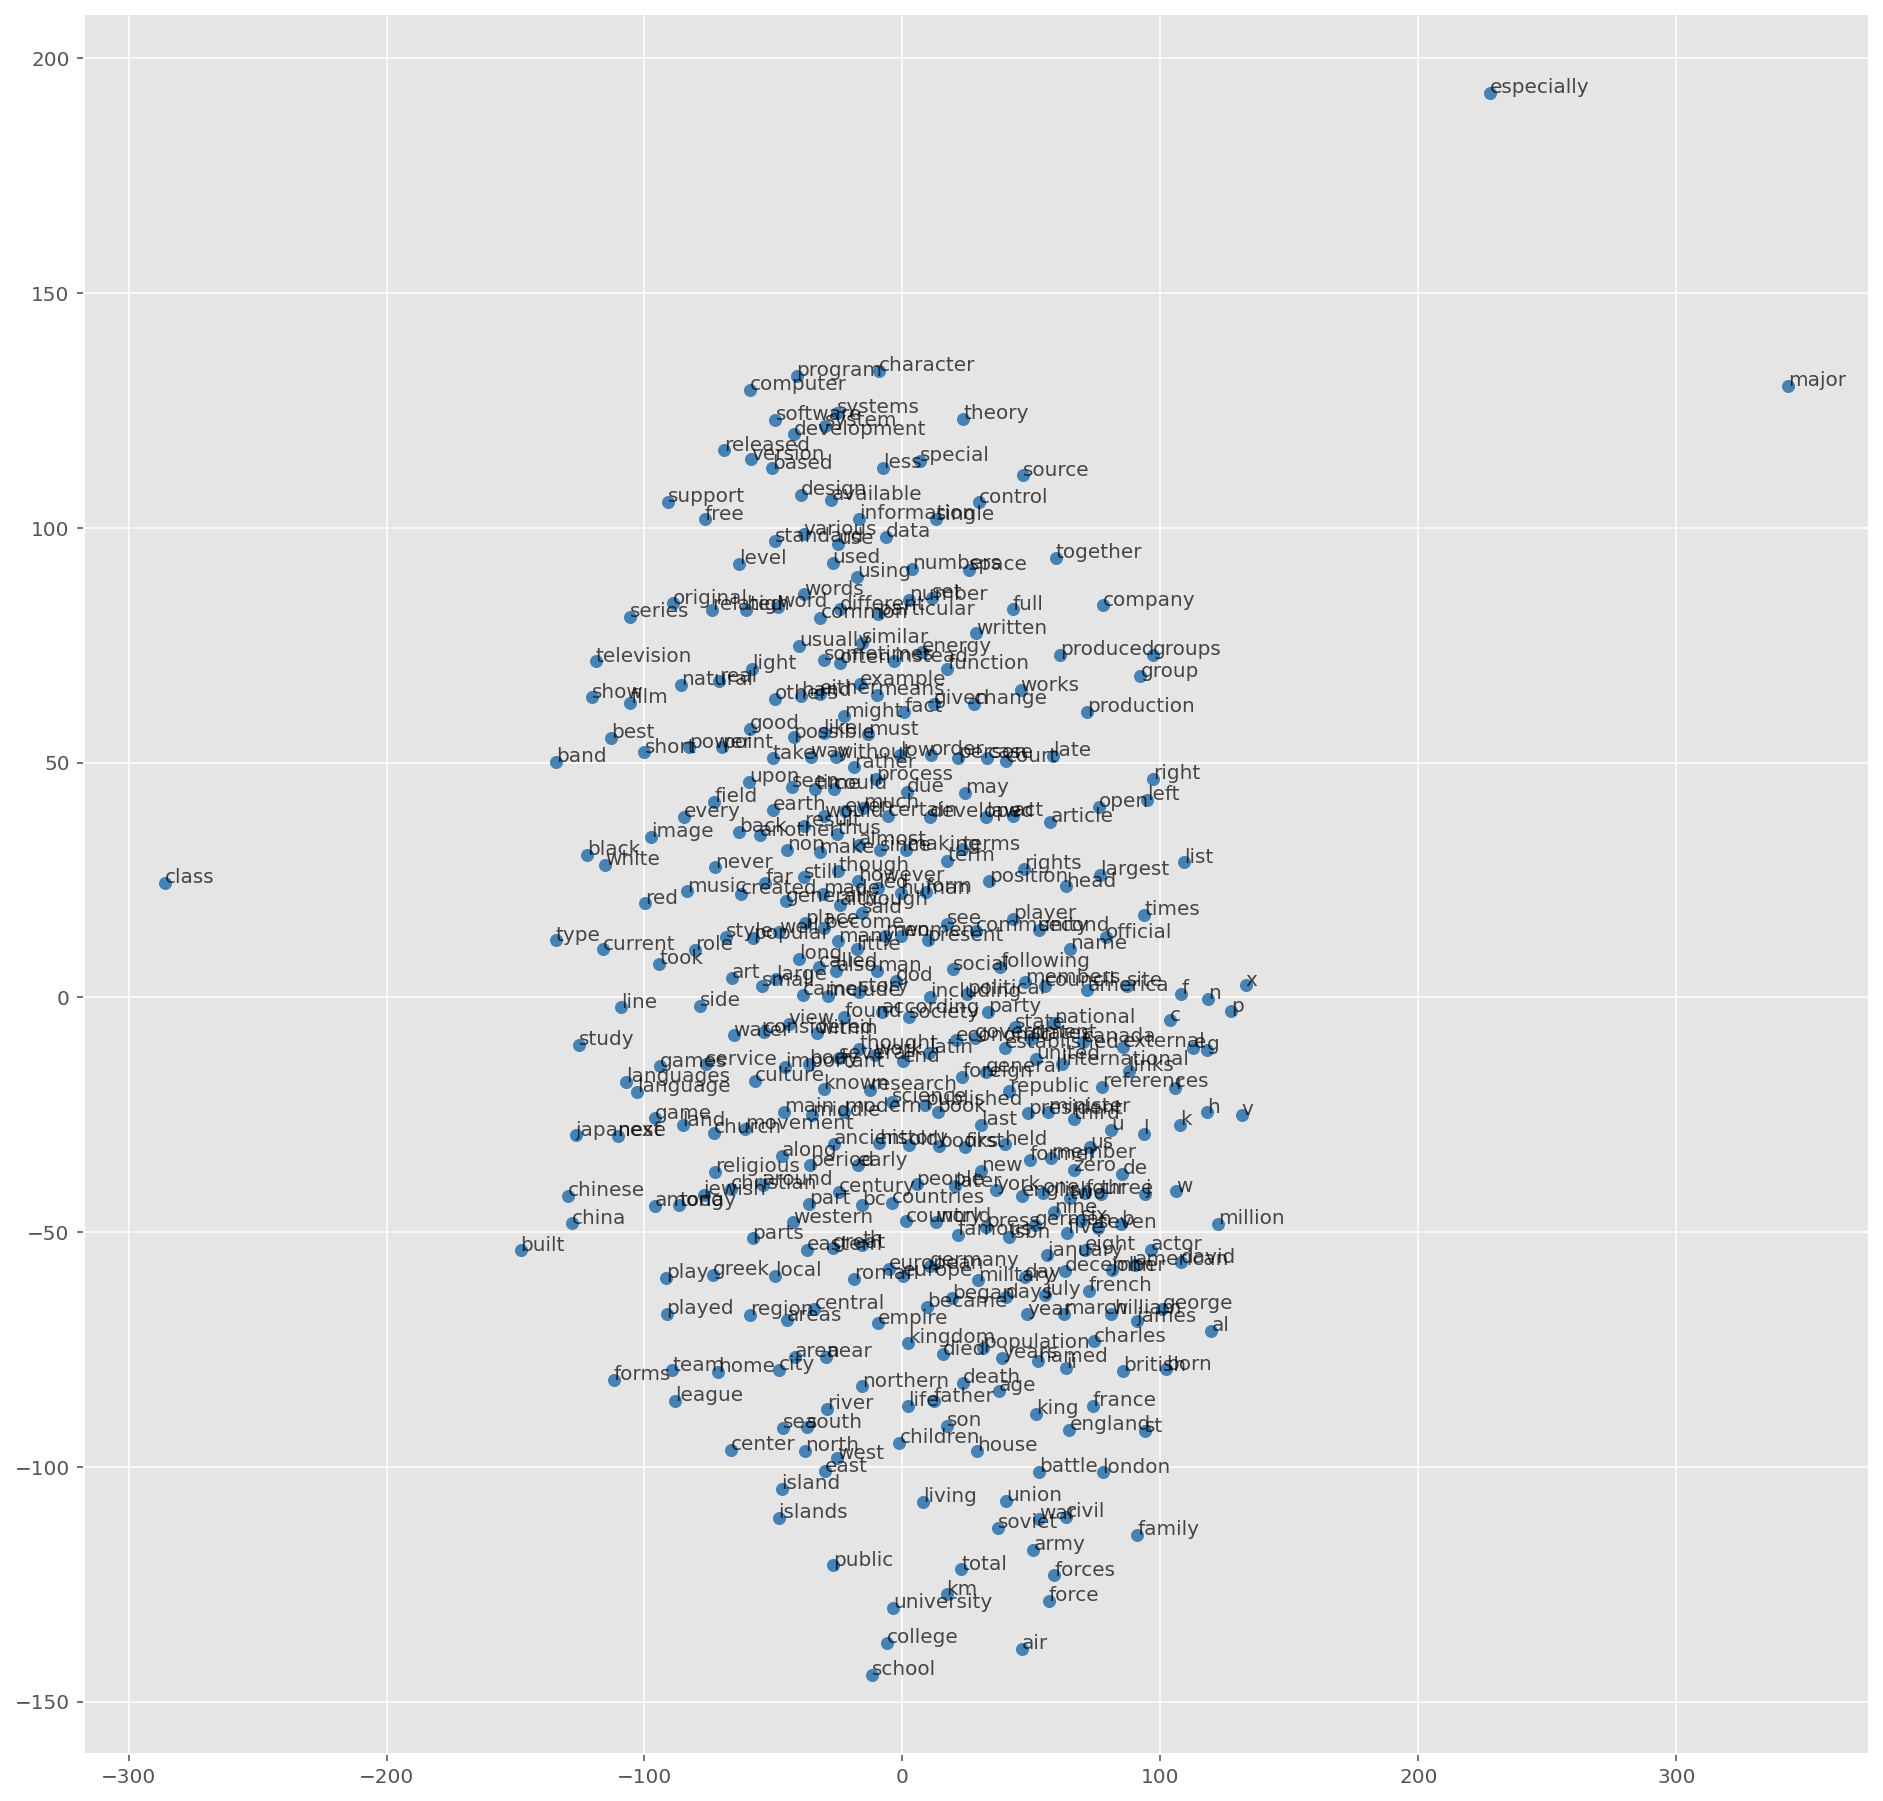

In [18]:
visualization_tsne(embeddings, text8_dataset.id_to_tokens, nb_words = 400)